This notebook serves as an example of using PySpark to explore big data, as well as explore the Spotify API functionality, and build a deep-embedding recommendation system. I have some good examples of SQL queries for EDA

In [1]:
%%capture
!pip install pyspark
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
sns.set_palette('rainbow')
sns.set_style('whitegrid')
import plotly.express as px
# these 2 lines fix a sporatic loading error in plotly
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
sns.set_style('darkgrid')
# pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col
from sklearn.pipeline import Pipeline
# from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")


In [3]:
CSV_FILE= '/Users/AayushMaharjan-octr/Desktop/pyspark/Final database.csv'
# CSV_FILE= 'Database to calculate popularity.csv'

In [3]:
# from pyspark.ml.regression import LinearRegression
# from pyspark.mllib.evaluation import RegressionMetrics

# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
# from pyspark.ml.feature import VectorAssembler, StandardScaler
# from pyspark.ml.evaluation import RegressionEvaluator

From SparkByExample:
> A spark session unifies all the different contexts, and you can access all the different contexts by invoking them on the spark session object. A Spark “driver” is an application that creates a SparkContext for executing one or more jobs in the Spark cluster. It allows your Spark/PySpark application to access Spark Cluster with the help of Resource Manager.
> 
> When you create a SparkSession object, SparkContext is also created and can be retrieved using spark.sparkContext. SparkContext will be created only once for an application; even if you try to create another SparkContext, it still returns existing SparkContext.

In [4]:
spark = SparkSession.builder.master("local[2]").appName("Spotify-Huge-Dataset").getOrCreate() #.enableHiveSupport()
spark

In [5]:
# Old way depreciated in 3.0.0
sc = spark.sparkContext
sqlContext = SQLContext(sc)
# sqlContext = SQLContext(spark)

Note I'm fixing the numerical features after loading the df. This is much slower than defining the schema before loading into a spark dataframe. I'll come back and define the schema explicitely later when I have some free time.

In [6]:
df = spark.read.option("header", True).csv(CSV_FILE)
df = df.withColumn("Release_date", F.to_date("Release_date", "yyyy-MM-dd"))
numerical_features = ['danceability', 'energy', 'instrumentalness', 'valence', 'liveliness', 'speechiness', 'acoustics',
                      'instrumentalness', 'tempo', 'duration_ms', 
                      'time_signature', 'Days_since_release', 'n_words']

for c in numerical_features:
    df = df.withColumn(c, df[c].cast("float"))
    
cols_to_drop = ['syuzhet_norm', 'bing_norm', 'afinn_norm', 'nrc_norm', 'syuzhet', 'bing'] 
for c in cols_to_drop:
    df.drop(c).collect()
    
df.printSchema()
# df.show(n=1, truncate=False, vertical=True)

root
 |-- Country0: string (nullable = true)
 |-- Uri: string (nullable = true)
 |-- Popularity: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Album/Single: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Artist_followers: string (nullable = true)
 |-- Explicit: string (nullable = true)
 |-- Album9: string (nullable = true)
 |-- Release_date: date (nullable = true)
 |-- Track_number: string (nullable = true)
 |-- Tracks_in_album: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acoustics: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveliness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- duration_ms: float (nul

# EDA
Some good SQL queries, Plotly figures, and examples of using pyspark to filter results from a large dataset.

In [7]:
# how many unique songs are there in the dataset?
df.select(["Title","Artist"]).distinct().count()

56241

In [8]:
print("Dataset Shape using spark syntax:\n",(df.count(), len(df.columns)))

Dataset Shape using spark syntax:
 (170633, 151)


Most popular artist, all countries. Each tally represents a song on a given day (during the last 3 days) that was one of the most 200 most played songs on that day. An artist can have multiple songs per day, and the same song can be counted on again on subsequent days.

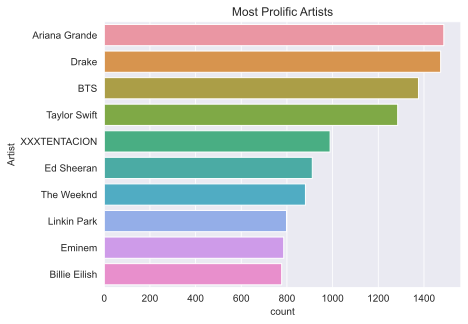

In [24]:
# each count is a song that was in the top 200 most played on a day on spotify during the last 3 years
result_df = (df.groupBy("Artist")
               .count()
               .orderBy("count", ascending=False)
               .limit(10)
               .toPandas()
            )
px.bar(result_df, y='Artist', x='count', title='Most Prolific Artists')
# same as above but with seaborn (sometimes plotly doesn't show up in the published notebok)
sns.barplot(data=result_df, y='Artist', x='count').set_title('Most Prolific Artists');

`CreateOrReplaceTempView` will create a temporary view of the table on memory. It won't persist, but you can run SQL queries on top of it. You can always force it to cache/persits with `saveAsTable`.

In [11]:
df.createOrReplaceTempView("df_table")

In [12]:
print("Now using the SQL Context. We can check it's the same length as before")
query = """
    SELECT Count(*) as Dataset_Length
    FROM df_table
"""
res = spark.sql(query).show()

Now using the SQL Context. We can check it's the same length as before
+--------------+
|Dataset_Length|
+--------------+
|        170633|
+--------------+



In [13]:
# Most popular artist (by sum of popularity of songs) in the USA
query = """
SELECT
                                    Artist, 
       ROUND(SUM(Popularity), 2) AS Populartiy
FROM df_table
WHERE USA == 1
GROUP BY Artist
ORDER BY AVG(Popularity) DESC
LIMIT 10
"""

res = spark.sql(query)
res.show(10, truncate=False)

+------------------------------+----------+
|Artist                        |Populartiy|
+------------------------------+----------+
|Post Malone - Quavo           |130719.15 |
|XXXTENTACION - Trippie Redd   |97016.35  |
|Meek Mill - Drake             |83235.95  |
|Post Malone - 21 Savage       |159633.25 |
|Billie Eilish - Khalid        |79693.9   |
|Marshmello - Bastille         |74560.5   |
|Cardi B - Bad Bunny - J Balvin|74381.6   |
|Migos - Lil Uzi Vert          |70138.2   |
|BlocBoy JB - Drake            |69576.75  |
|Kendrick Lamar - Zacari       |67838.15  |
+------------------------------+----------+



In [14]:
# select only the songs released in 2000
(df.filter(F.year(df['Release_date']) == 2000)
   .select('Title', 'Artist','Release_date', 'Genre')
   .distinct()
   .show(5, truncate=False)
)

+-------------------+-----------+------------+-----------------+
|Title              |Artist     |Release_date|Genre            |
+-------------------+-----------+------------+-----------------+
|one step closer    |Linkin Park|2000-10-24  |alternative metal|
|my december        |Linkin Park|2000-10-24  |alternative metal|
|crawling           |Linkin Park|2000-10-24  |alternative metal|
|in the end         |Linkin Park|2000-10-24  |alternative metal|
|a place for my head|Linkin Park|2000-10-24  |alternative metal|
+-------------------+-----------+------------+-----------------+
only showing top 5 rows



### Most Popular Song per Decade
First with a nested query and using pandas to drop duplicates. Then optimized with [scalar-aggregate reduction](https://www.stevenmoseley.com/blog/tech/high-performance-sql-correlated-scalar-aggregate-reduction-queries)

In [15]:
query = """
SELECT
        ROUND(Year(Release_date), -1) AS Decade,
        Round(Popularity, 2)          AS Popularity,
                                         Title,
                                         Artist
FROM df_table
INNER JOIN (SELECT Max(Popularity) as mp
            FROM df_tableS
            WHERE ROUND(Year(Release_date), -1) IS NOT NULL
            AND USA == 1
            GROUP BY ROUND(Year(Release_date), -1)
           ) AS temp
ON temp.mp = df_table.Popularity
ORDER BY Decade ASC, Popularity ASC
"""

res = spark.sql(query)
res.toPandas().drop_duplicates(subset='Decade', keep="last")

,Decade,Popularity,Title,Artist
10,NaN,98.60,say it loud - im black and im proud,James Brown
11,1940.0,840.50,have yourself a merry little christmas,Judy Garland
12,1950.0,997.60,mele kalikimaka,Bing Crosby - The Andrews Sisters
15,1960.0,9704.95,blue christmas,Elvis Presley
16,1970.0,98.40,me and julio down by the schoolyard,Paul Simon
24,1980.0,98.60,listen to her heart,Tom Petty and the Heartbreakers
32,1990.0,98.40,home for the holidays - 1959 version,Perry Como
40,2000.0,9476.05,feliz navidad,José Feliciano
75,2010.0,98.60,suomirokkia,Aknestik
383,2020.0,99912.30,drip too hard,Lil Baby - Gunna


In [16]:
# highly optimized version of the above query via scalar-aggregate-reduction
query = """
SELECT
    ROUND(Year(Release_date), -1) as Decade,
    ROUND(Max(Popularity), 2) as Popularity,
    SUBSTRING(MAX(CONCAT(LPAD(Popularity, 11, 0), Title)), 12) AS Title,
    SUBSTRING(MAX(CONCAT(LPAD(Popularity, 11, 0), Artist)), 12) AS Artist
FROM
    df_table
WHERE
    ROUND(Year(Release_date), -1) IS NOT NULL
    AND USA == 1
GROUP BY Decade
ORDER BY Decade ASC
"""

spark.sql(query).show()

+------+----------+--------------------+--------------------+
|Decade|Popularity|               Title|              Artist|
+------+----------+--------------------+--------------------+
|  1940|     840.5|     white christmas|Bing Crosby - Ken...|
|  1950|     997.6|ill be home for c...|         Bing Crosby|
|  1960|   9704.95|    jingle bell rock|         Bobby Helms|
|  1970|      98.4|what christmas me...|       Stevie Wonder|
|  1980|      98.6|dreams - 2004 rem...|       Fleetwood Mac|
|  1990|     97.75|            spoonman|         Soundgarden|
|  2000|   9476.05|       feliz navidad|      José Feliciano|
|  2010|     97.75|         tongue tied|           Grouplove|
|  2020|   99912.3|       drip too hard|    Lil Baby - Gunna|
+------+----------+--------------------+--------------------+



### Most popular Genre per decade

In [17]:
 # Most popular genres, period.
query = """
SELECT Genre, COUNT(*) AS Tally
FROM df_table
GROUP BY Genre
ORDER BY Tally DESC
"""
spark.sql(query).show(5)

+---------+-----+
|    Genre|Tally|
+---------+-----+
|dance pop|25351|
|    latin| 7591|
|      pop| 7146|
|    k-pop| 4053|
|      n-a| 3952|
+---------+-----+
only showing top 5 rows



In [18]:
query = """
SELECT
      ROUND(Year(Release_date), -1) AS Decade,
      Genre, COUNT(Genre)           AS counts
FROM  df_table
WHERE ROUND(Year(Release_date), -1) IS NOT NULL
GROUP BY Decade, Genre
ORDER BY COUNT(Genre) DESC
"""

res = (spark.sql(query)
            .dropDuplicates(subset=['Decade'])
            .orderBy('Decade')
            .show()
      )
# res.toPandas().drop_duplicates(subset='Decade', keep="first")

+------+-------------------+------+
|Decade|              Genre|counts|
+------+-------------------+------+
|  1900|vocal harmony group|     1|
|  1930|        movie tunes|     1|
|  1940|    adult standards|    39|
|  1950|    adult standards|    36|
|  1960|    adult standards|   186|
|  1970|       classic soul|   152|
|  1980|         album rock|   379|
|  1990|         irish rock|   170|
|  2000|  alternative metal|   477|
|  2010|          dance pop|  1052|
|  2020|          dance pop| 23496|
+------+-------------------+------+



## For each track, what day was it most popular?
(Just for a small selection of them)

In [19]:
query = """
SELECT Title, Artist, Release_date, MAX(Popularity)
FROM df_table
WHERE Artist == "Paulo Londra"
GROUP BY Title, Artist, Release_date
LIMIT 10
"""

res = spark.sql(query).show()

+--------------------+------------+------------+------------------+
|               Title|      Artist|Release_date|   max(Popularity)|
+--------------------+------------+------------+------------------+
|          adan y eva|Paulo Londra|  2018-11-05| 849.6000000000001|
|          adan y eva|Paulo Londra|  2019-05-23| 57194.60000000001|
|    chica paranormal|Paulo Londra|  2018-07-24|           6341.35|
|    chica paranormal|Paulo Londra|  2019-05-23|           9409.05|
|condenado para el...|Paulo Londra|  2017-12-04| 617.6000000000001|
|condenado para el...|Paulo Londra|  2018-11-03|             852.0|
|condenado para el...|Paulo Londra|  2019-05-23| 586.7500000000001|
|confiado & tranquilo|Paulo Londra|  2017-05-30|375.20000000000016|
|        cámara lenta|Paulo Londra|  2017-10-07| 8088.800000000004|
|      demasiado loco|Paulo Londra|  2019-05-23| 6337.350000000001|
+--------------------+------------+------------+------------------+



## Let's see how music changed over the decades

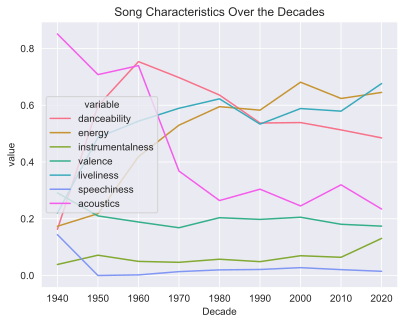

In [52]:
sound_features = ['danceability', 'energy', 'instrumentalness', 'valence', 'liveliness', 'speechiness', 'acoustics']
col_names = ['Decade']
col_names.extend(sound_features)

df_music_features = (df.sample(.2, seed=42)
                       .groupBy(F.round(F.year(df.Release_date), -1))
                       .agg({feature: 'mean' for feature in sound_features})
                       .toDF(*col_names)
                       .orderBy('Decade')
                       .toPandas()
                       .dropna(axis=0)
                    )
fig = px.line(df_music_features, x='Decade', y=sound_features, title='Song Characteristics Over the Decades')
fig.show()
# same as above but with seaborn. (sometimes plotly doesn't show up in the published notebok)
sns.lineplot(data=pd.melt(df_music_features, ['Decade']), x='Decade', y='value', hue='variable').set_title('Song Characteristics Over the Decades');

# Clustering

There are a few possible approaches for comparing song similarities. One is to just use the continuous, numerical variables (things like danceability, energy, etc.) and do PCA or k-means or some other way to reduce dimensionality.  If you're just considering the song features (continuous variables) you could just create a feature vector and look at the cosine similartity to find the most similar sounding song, taking into account the numerical features and the one-hot-encoded countries.

Some options: 
- [Non-linear PCA (NLPCA)](https://pubmed.ncbi.nlm.nih.gov/22176263/)
- [Factor Analysis of Mixed Data (FAMD)](https://github.com/MaxHalford/Prince#factor-analysis-of-mixed-data-famd)

Alternatively, we can create an embedding, where we map all the songs into an n-dimensional feature space and then look for the most similar vectors in this space (probably with k-NNN. Then we can get the k-most similar songs). 

## First check out the cosine similiarty of song feature vectors

In [29]:
###### First KPop ######
query_kpop = """
SELECT Title, Artist, {}
FROM df_table
WHERE `k-pop` = 1
""".format(', '.join(numerical_features))

df_kpop_songs = (spark.sql(query_kpop)
                      .sample(.1)
                      .dropna()
                      .toPandas() # don't do this, it's better to sample before querying
                )
####### Now Rap #######
query_rap = """
SELECT Title, Artist, {}
FROM df_table
WHERE rap = 1
""".format(', '.join(numerical_features))

df_rap_songs = (spark.sql(query_rap)
                     .sample(.1)
                     .dropna()
                     .toPandas() # don't do this, it's better to sample before querying
               )
df_rap_songs.head()

,Title,Artist,danceability,energy,instrumentalness,valence,liveliness,speechiness,acoustics,instrumentalness,tempo,duration_ms,time_signature,Days_since_release,n_words
0,betrayed,Lil Xan,0.821,0.434,0.00000,0.241,0.1280,0.118,0.434,0.00000,120.012001,187173.0,4.0,953.0,346.0
1,ball for me,Post Malone - Nicki Minaj,0.797,0.550,0.00000,0.543,0.0786,0.240,0.513,0.00000,134.205994,206267.0,4.0,932.0,422.0
2,ball for me,Post Malone - Nicki Minaj,0.797,0.550,0.00000,0.543,0.0786,0.240,0.513,0.00000,134.205994,206267.0,4.0,932.0,422.0
3,ball for me,Post Malone - Nicki Minaj,0.797,0.550,0.00000,0.543,0.0786,0.240,0.513,0.00000,134.205994,206267.0,4.0,932.0,422.0
4,revenge,XXXTENTACION,0.746,0.251,0.00203,0.180,0.1060,0.259,0.782,0.00203,139.998993,120027.0,4.0,1177.0,475.0


In [30]:
df_kpop_songs.head()

,Title,Artist,danceability,energy,instrumentalness,valence,liveliness,speechiness,acoustics,instrumentalness,tempo,duration_ms,time_signature,Days_since_release,n_words
0,outnumbered,Dermot Kennedy,0.614,0.684,0.000000,0.258,0.0976,0.1570,0.24700,0.000000,156.850006,245700.0,4.0,520.0,241.0
1,outnumbered,Dermot Kennedy,0.614,0.684,0.000000,0.258,0.0976,0.1570,0.24700,0.000000,156.850006,245700.0,4.0,520.0,241.0
2,outnumbered,Dermot Kennedy,0.614,0.684,0.000000,0.258,0.0976,0.1570,0.24700,0.000000,156.850006,245700.0,4.0,520.0,241.0
3,outnumbered,Dermot Kennedy,0.614,0.684,0.000000,0.258,0.0976,0.1570,0.24700,0.000000,156.850006,245700.0,4.0,520.0,241.0
4,chicken noodle soup,j-hope - Becky G,0.826,0.817,0.000011,0.168,0.2940,0.0921,0.00502,0.000011,97.053001,235497.0,4.0,414.0,474.0


In [31]:
# it might be better to used a normalized cosine similarity instead of scaling first and then doing it.
from scipy import spatial
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
transformer = Normalizer()

scaled_kpop_df = scaler.fit_transform(df_kpop_songs.iloc[:, 2:]) # drop the title and artist with the iloc
scaled_rap_df = scaler.fit_transform(df_rap_songs.iloc[:, 2:])


# cos similarity of a rap and a k-pop song
song1 = np.array(scaled_rap_df[1])
song2 = np.array(scaled_kpop_df[2])
result = 1 - spatial.distance.cosine(song1, song2)
print("Cosine similarity of a rap and a k-pop song:", result)

Cosine similarity of a rap and a k-pop song: 0.9027756452560425


In [32]:
# cos similarity of two rap songs
song1 = np.array(scaled_rap_df[1])
song2 = np.array(scaled_rap_df[10])
result = 1 - spatial.distance.cosine(song1, song2)
print("Cosine similarity of two rap songs:", result)

Cosine similarity of two rap songs: 0.9831744432449341


## Dimentionality reduction
This is useful for visualizing kmeans clustering later. One mistake people make with PCA, is assuming that the dimentions you get will be interpretable. In this case, we're going to take two types of music (Kpop and Rap), and then try reducing all the numeric, musical features down to two dimentions. The two dimentions won't really represent the genre of the music, but we can pretend that this is true. When we do KMeans clustering later on, we can visualize it on these two PCA axes.

In [33]:
# let's add an OHE genre encoding
df_rap_songs = df_rap_songs.assign(is_rap=1,
                                   is_kpop=0
                                   )
df_kpop_songs = df_kpop_songs.assign(is_rap=0,
                                     is_kpop=1
                                     )
df_rap_and_kpop = pd.concat([df_rap_songs, df_kpop_songs])
X = scaler.fit_transform(df_rap_and_kpop.iloc[:, 2:])

pca = PCA(n_components=10)
pca.fit(X)
print(pca.explained_variance_ratio_)

[0.47780918 0.12723261 0.10331381 0.07655133 0.05012893 0.04026756
 0.03220208 0.02855147 0.01974027 0.0187642 ]


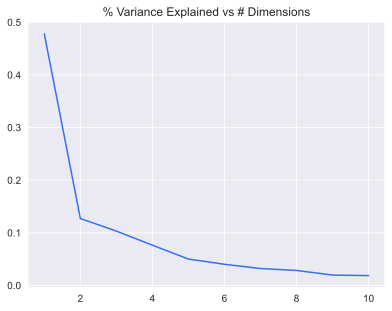

In [34]:
sns.lineplot(x=[x for x in range(1, 11)], y=pca.explained_variance_ratio_).set_title("% Variance Explained vs # Dimensions");

As expected, it's able to explain most the vairance using 1 dimension. This roughly corresponds to "genre," which instead was encoded as either `is_rap` or `is_kpop`

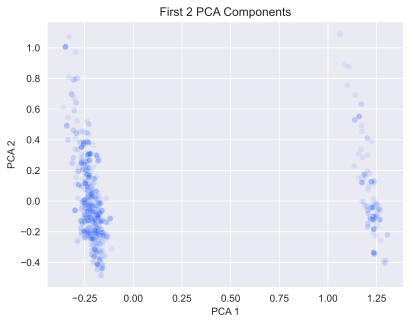

In [35]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
PCA_components = pd.DataFrame(principalComponents)

# sns.scatterplot(data=principalComponents, alpha=.1)
sns.scatterplot(x=PCA_components[0], y=PCA_components[1], alpha=.1).set_title("First 2 PCA Components");
plt.xlabel('PCA 1');
plt.ylabel('PCA 2');

The first component is particularly excellent at separation

## Kmeans Clustering

Find the optimum number of clusters with an elbow plot. View the top 2 PCA clusters, and then use kmeans with various number of clusters. The "Scree" plot below, shows the percent of variance explained as a function of the number of clusters used

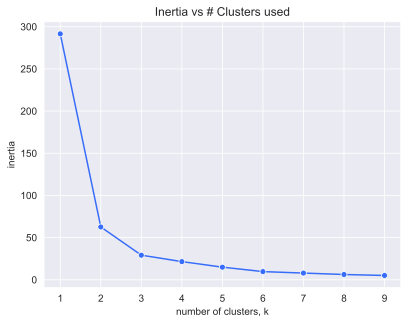

In [36]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:2])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
sns.lineplot(x=ks, y=inertias, marker='o').set_title("Inertia vs # Clusters used")
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Again, as expected, 2 clusters seems to make sense

In [37]:
km = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

In [38]:
df_pca_kmeans_plot = pd.concat([PCA_components, pd.Series(y_km)], axis=1)
df_pca_kmeans_plot.columns = ['PCA_1', 'PCA_2', 'Cluster']

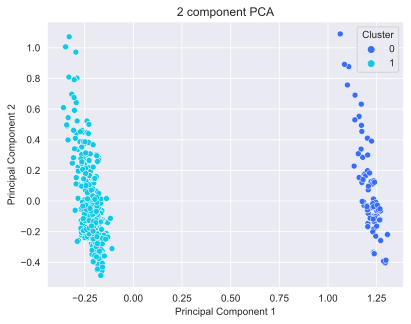

In [39]:
sns.scatterplot(data=df_pca_kmeans_plot, x='PCA_1', y='PCA_2', hue='Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 component PCA');

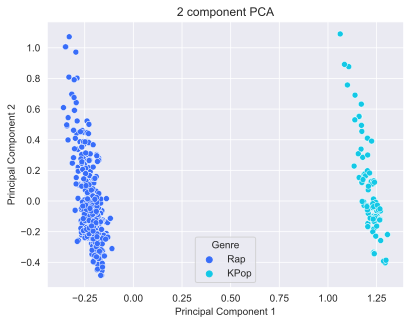

In [40]:
# now color by genre instead of cluster
df_final = pd.concat([df_pca_kmeans_plot, df_rap_and_kpop.reset_index()['is_rap']], axis=1)
df_final['is_rap'] = df_final['is_rap'].replace({1:'Rap', 0: 'KPop'})
df_final['Cluster'] = df_final['Cluster'].replace({1:'Cluster 2', 0: 'Cluster 1'})
df_final = df_final.rename(columns={'is_rap': 'Genre'})

sns.scatterplot(data=df_final, x='PCA_1', y='PCA_2', hue='Genre')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 component PCA');
# px.scatter(df_final, x='PCA_1', y='PCA_2', color='Genre', hover_data=['Genre'])

Now, would it work it be able to pick out genre and group into two clusters as nicely, if we excluded the "Genre" features from the training labels?

[0.24459557 0.19159462 0.14410159 0.11210032 0.07476356 0.06108724
 0.05291369 0.03676652 0.03478003 0.02420069]


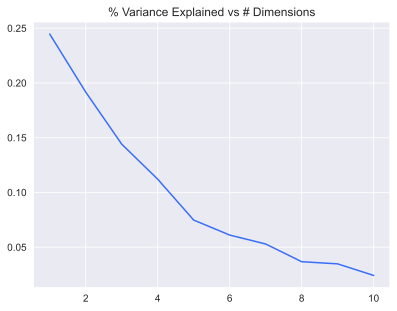

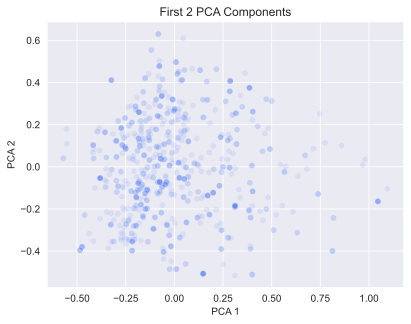

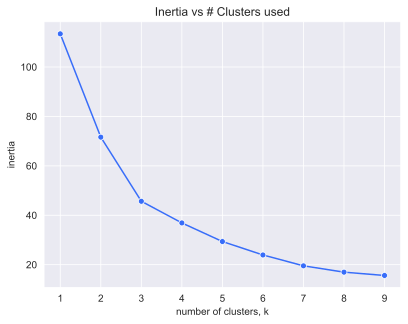

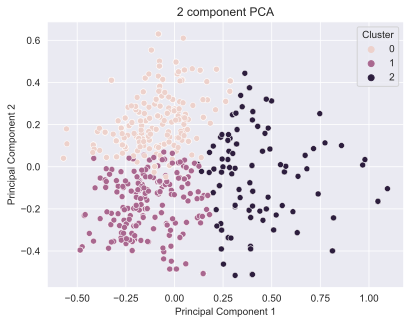

In [41]:
df_rap_and_kpop = pd.concat([df_rap_songs, df_kpop_songs])
rap_kpop_labels = df_rap_and_kpop[['is_rap', 'is_kpop']]
df_rap_and_kpop = df_rap_and_kpop.drop(columns=['is_rap', 'is_kpop'])
X = scaler.fit_transform(df_rap_and_kpop.iloc[:, 2:])

pca = PCA(n_components=10)
pca.fit(X)
print(pca.explained_variance_ratio_)
sns.lineplot(x=[x for x in range(1, 11)], y=pca.explained_variance_ratio_).set_title("% Variance Explained vs # Dimensions")
plt.show()

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
PCA_components = pd.DataFrame(principalComponents)

# sns.scatterplot(data=principalComponents, alpha=.1)
sns.scatterplot(x=PCA_components[0], y=PCA_components[1], alpha=.1).set_title("First 2 PCA Components");
plt.xlabel('PCA 1');
plt.ylabel('PCA 2');
plt.show()


ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:2])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
sns.lineplot(x=ks, y=inertias, marker='o').set_title("Inertia vs # Clusters used")
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

df_pca_kmeans_plot = pd.concat([PCA_components, pd.Series(y_km)], axis=1)
df_pca_kmeans_plot.columns = ['PCA_1', 'PCA_2', 'Cluster']
sns.scatterplot(data=df_pca_kmeans_plot, x='PCA_1', y='PCA_2', hue='Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 component PCA');

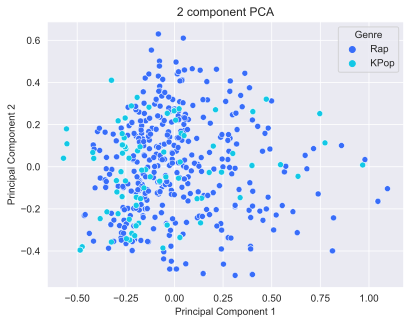

In [42]:
df_final = pd.concat([df_pca_kmeans_plot, rap_kpop_labels.reset_index()['is_rap']], axis=1)
df_final['is_rap'] = df_final['is_rap'].replace({1:'Rap', 0: 'KPop'})
df_final['Cluster'] = df_final['Cluster'].replace({1:'Cluster 2', 0: 'Cluster 1'})
df_final = df_final.rename(columns={'is_rap': 'Genre'})

# px.scatter(df_final, x='PCA_1', y='PCA_2', color='Genre', hover_data=['Cluster'])
sns.scatterplot(data=df_final, x='PCA_1', y='PCA_2', hue='Genre')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 component PCA');

Without providing PCA the genre as a feature, it separates the data very differently. You can see that it makes no attempt to separate by genre (when we add it back in and plot, coloring by genre instead of cluster). And interestingly, it suggests that three clusters is the best separation, instead of two.

# Find the most similar song
We could do something like fit_transform the entire dataset, then write a function to loop through all the poosible songs (only like 60k of them), and then return the minimum. We need to be careful or at least selective about the features though, because trying to OHE all the variables might exceed our RAM limit

In [43]:
# we might want to grab the URI too, to compare how they sound later. I'll skip for now
query_all = """
SELECT Title, Artist, Genre, {}
FROM df_table
""".format(', '.join(numerical_features))

df_all_songs = (spark.sql(query_all)
                     .dropna()
                     .toPandas()
                     .drop_duplicates(['Title', 'Artist'])
                     .reset_index(drop=True)
                )

In [44]:
df_all_songs.columns

Index(['Title', 'Artist', 'Genre', 'danceability', 'energy',
       'instrumentalness', 'valence', 'liveliness', 'speechiness', 'acoustics',
       'instrumentalness', 'tempo', 'duration_ms', 'time_signature',
       'Days_since_release', 'n_words'],
      dtype='object')

In [45]:
df_all_songs_ohe = pd.get_dummies(df_all_songs.drop(columns='Title'))
scaled_df_all_songs_ohe = scaler.fit_transform(df_all_songs_ohe)

In [46]:
def get_most_similar_song(title, artist):
    title = title.lower()
    # get the vector for the requested song
    song_idx = df_all_songs.query(f"Title == '{title}' and Artist == '{artist}'").index.values[0]
    song_vector = scaled_df_all_songs_ohe[song_idx]
    # find the most similar song
    min_difference = 1
    closest_song_idx = 0
    for index, song in enumerate(scaled_df_all_songs_ohe):
        distance = spatial.distance.cosine(song_vector, song)
        if distance < min_difference:
            if index == song_idx:
                pass
            else:
                min_difference = distance
                closest_song_idx = index #np_iterator.index
    # get the title and the artist of the most similar song
    closest_song = df_all_songs.loc[closest_song_idx,['Title', 'Artist']]
    print("Closest Song:\n-------------", closest_song, sep="\n")
    return closest_song_idx

In [47]:
get_most_similar_song("Numb", "Linkin Park")

Closest Song:
-------------
Title        crawling
Artist    Linkin Park
Name: 1470, dtype: object


1470

In [48]:
spark.sql("SELECT Artist, Title FROM df_table WHERE Artist LIKE 'Radio%'").distinct().show(50)

+---------+------------------+
|   Artist|             Title|
+---------+------------------+
|Radiohead|             creep|
|Radiohead|      karma police|
|Radiohead|        man of war|
|Radiohead|          ill wind|
|Radiohead|      high and dry|
|Radiohead|      no surprises|
|Radiohead|  paranoid android|
|Radiohead|fake plastic trees|
+---------+------------------+



In [49]:
get_most_similar_song("creep", "Radiohead")

Closest Song:
-------------
Title           californication
Artist    Red Hot Chili Peppers
Name: 5955, dtype: object


5955